In [2]:
import pandas as pd
from sklearn import preprocessing
import matplotlib.pyplot as plt

In [3]:
# Import the already encoded dataset
btvote = pd.read_pickle('../data/btvote_encoded.pkl')
btvote.head()

,party,vote_19001,vote_19002,vote_19003,vote_19004,vote_19005,vote_19006,vote_19007,vote_19008,vote_19009,...,vote_19235,vote_19236,vote_19237,vote_19238,vote_19239,vote_19240,vote_19241,vote_19242,vote_19243,vote_19244
0,CDU/CSU,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0
1,SPD,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,1.0,1.0,1.0,1.0,1.0,0.0,NaN,NaN,NaN
2,Linke,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.0,0.0
3,CDU/CSU,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,NaN
4,Linke,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.0,NaN


# Split data and encode target variable

In [4]:
# Split dataframe in 'data' and 'target'
btvote_data = btvote.drop('party', axis=1)
btvote_target = btvote['party']

# Encode the target variable
label_encoder = preprocessing.LabelEncoder()
btvote_target = label_encoder.fit_transform(btvote_target)

# Pipeline and GridSearch setup

In the pipeline we include the SimpleImputer with the strategy 'most_frequent' as a result of the experiments in the previous notebook.\
For Balancing, we try out RandomOverSampler, RandomUnderSampler and no Sampling.\
As an estimator, we consider nearest-neighbor, Decision Tree and Naive Bayes. In a later notebook more models will be analysed in detail. For the moment, this selection of estimators should just ensure well-founded results for the different balancing approaches.

In [15]:
from imblearn.pipeline import Pipeline
# imputer
from sklearn.impute import KNNImputer
# balancing
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
# classifiers
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier

# Pipeline
pipeline = Pipeline([('imputer', KNNImputer(n_neighbors=1)), ('balancing', None), ('estimator', None)])

# set parameter grid
parameters = {
    'balancing': [RandomOverSampler(), RandomUnderSampler(), None],
    'estimator': [KNeighborsClassifier(n_neighbors=7), DecisionTreeClassifier(max_depth=5, random_state=42), GaussianNB()],
}

In [16]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, make_scorer

# specify the cross validation
stratified_10_fold_cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# define the scoring function
# Note: We use 'macro' as average as we want to evaluate the performance of each class equally, regardless of the class size
f1 = make_scorer(f1_score, average='macro')

# Balancing evaluation

In [17]:
# create the grid search instance
grid_search_estimator = GridSearchCV(pipeline, parameters, scoring=f1, cv=stratified_10_fold_cv, error_score='raise')

# run the grid search
grid_search_estimator.fit(btvote_data, btvote_target)

# results of all hyper-parameter combinations
results = pd.DataFrame(grid_search_estimator.cv_results_)

# pivot the results for better visualization
results['param_balancing'] = results['param_balancing'].astype(str)
results['param_estimator'] = results['param_estimator'].astype(str)
pivoted_results = results.pivot(index='param_balancing', columns='param_estimator', values='mean_test_score')
pivoted_results['Average'] = pivoted_results[['DecisionTreeClassifier(max_depth=5, random_state=42)','GaussianNB()','KNeighborsClassifier(n_neighbors=7)']].mean(axis=1)
display(pivoted_results)

param_estimator,"DecisionTreeClassifier(max_depth=5, random_state=42)",GaussianNB(),KNeighborsClassifier(n_neighbors=7),Average
param_balancing,,,,
None,0.824300,0.844530,0.864081,0.844304
RandomOverSampler(),0.824893,0.844530,0.861757,0.843726
RandomUnderSampler(),0.840584,0.841172,0.798211,0.826656


We already see that Balacing the data doesn't necessarily improve the macro F1-score. We now go further into detail by showing the confusion matrix for the different classification models.

In [18]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split

# Create train and test data
btvote_data_train, btvote_data_test, btvote_target_train, btvote_target_test = train_test_split(btvote_data, btvote_target, random_state=42)

### Naive Bayes

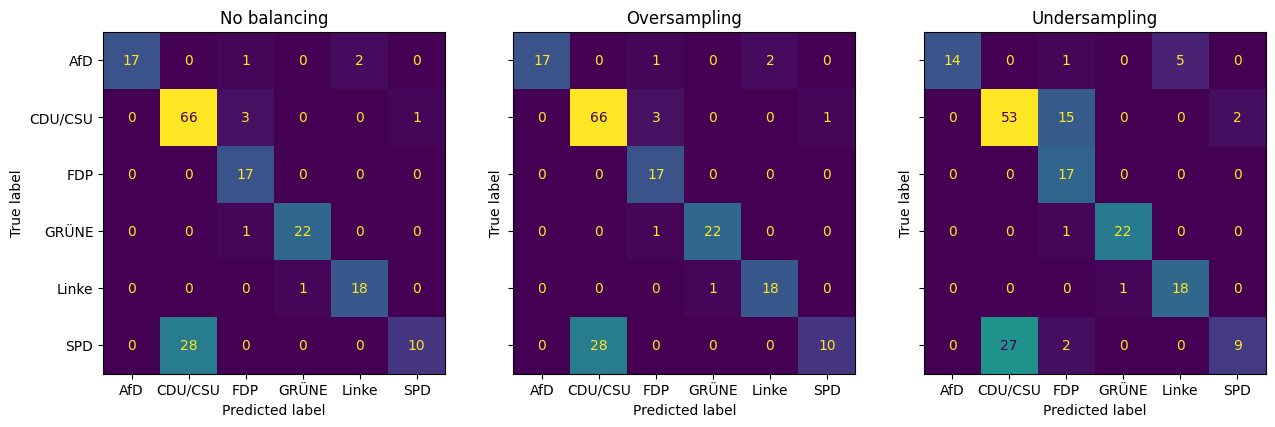

In [19]:
# Plot one confusion matrix for each balancing approach
fig, axs = plt.subplots(1, 3, sharey=True, figsize=(15,5))

# No balancing
pipeline.set_params(balancing=None, estimator=GaussianNB())
pipeline.fit(btvote_data_train, btvote_target_train)
prediction = pipeline.predict(btvote_data_test)
axs[0].set_title("No balancing")
ConfusionMatrixDisplay(confusion_matrix(btvote_target_test, prediction), display_labels=label_encoder.classes_).plot(ax=axs[0], colorbar=False)

# Oversampling
pipeline = pipeline.set_params(balancing=RandomOverSampler())
pipeline.fit(btvote_data_train, btvote_target_train)
prediction = pipeline.predict(btvote_data_test)
axs[1].set_title("Oversampling")
ConfusionMatrixDisplay(confusion_matrix(btvote_target_test, prediction), display_labels=label_encoder.classes_).plot(ax=axs[1], colorbar=False)

# Undersampling
pipeline = pipeline.set_params(balancing=RandomUnderSampler())
pipeline.fit(btvote_data_train, btvote_target_train)
prediction = pipeline.predict(btvote_data_test)
axs[2].set_title("Undersampling")
ConfusionMatrixDisplay(confusion_matrix(btvote_target_test, prediction), display_labels=label_encoder.classes_).plot(ax=axs[2], colorbar=False)

plt.show()

The Undersampler struggles a little more with differentiating between CDU/CSU and FDP, but overall, no clear differences are visible here.

### Decision Tree Classifier

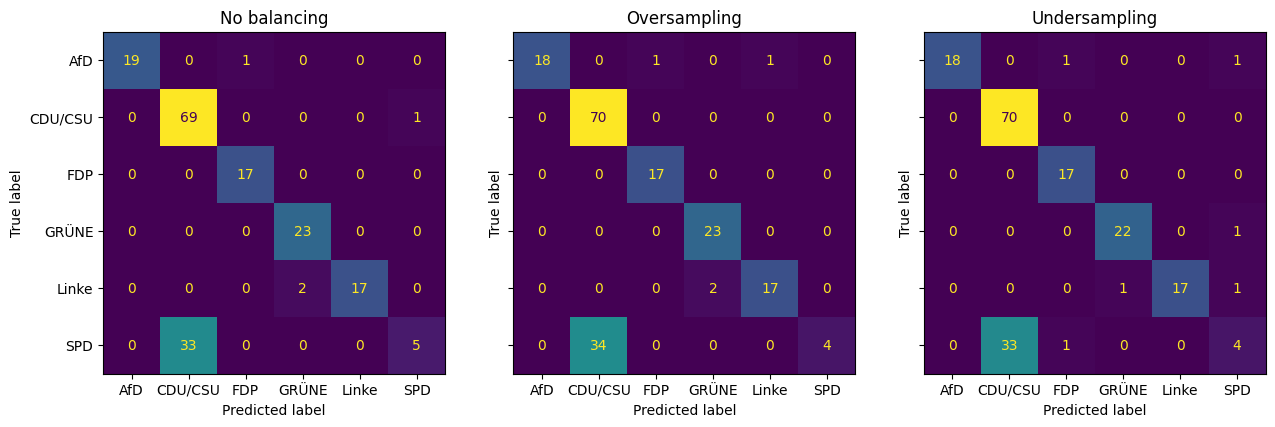

In [20]:
# Plot one confusion matrix for each balancing approach
fig, axs = plt.subplots(1, 3, sharey=True, figsize=(15,5))

# No balancing
pipeline.set_params(balancing=None, estimator=DecisionTreeClassifier(max_depth=5))
pipeline.fit(btvote_data_train, btvote_target_train)
prediction = pipeline.predict(btvote_data_test)
axs[0].set_title("No balancing")
ConfusionMatrixDisplay(confusion_matrix(btvote_target_test, prediction), display_labels=label_encoder.classes_).plot(ax=axs[0], colorbar=False)

# Oversampling
pipeline = pipeline.set_params(balancing=RandomOverSampler())
pipeline.fit(btvote_data_train, btvote_target_train)
prediction = pipeline.predict(btvote_data_test)
axs[1].set_title("Oversampling")
ConfusionMatrixDisplay(confusion_matrix(btvote_target_test, prediction), display_labels=label_encoder.classes_).plot(ax=axs[1], colorbar=False)

# Undersampling
pipeline = pipeline.set_params(balancing=RandomUnderSampler())
pipeline.fit(btvote_data_train, btvote_target_train)
prediction = pipeline.predict(btvote_data_test)
axs[2].set_title("Undersampling")
ConfusionMatrixDisplay(confusion_matrix(btvote_target_test, prediction), display_labels=label_encoder.classes_).plot(ax=axs[2], colorbar=False)

plt.show()

For all three approaches, a lot of SPD MPs are classified as CDU/CSU.

### Nearest Neighbor Classifier

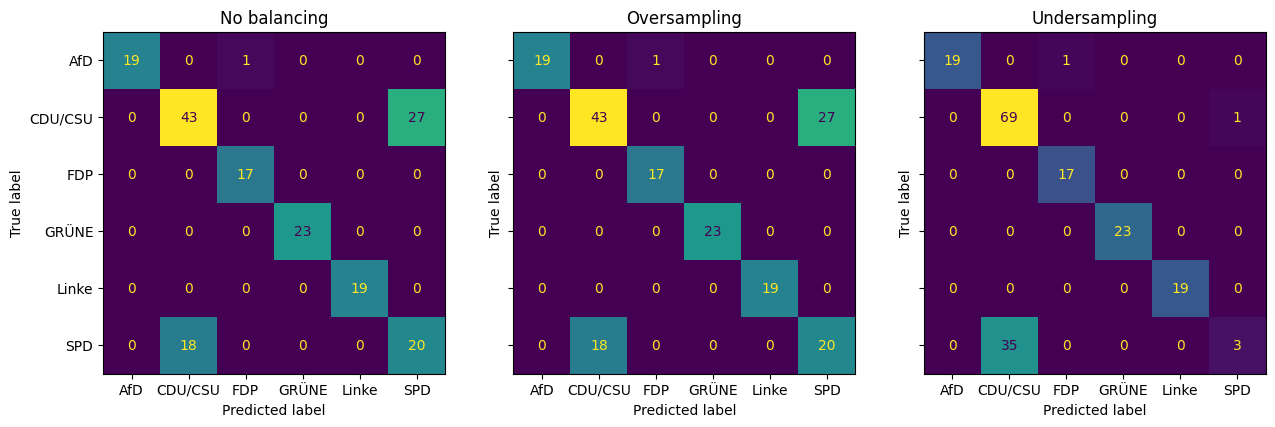

In [21]:
# Plot one confusion matrix for each balancing approach
fig, axs = plt.subplots(1, 3, sharey=True, figsize=(15,5))

# No balancing
pipeline.set_params(balancing=None, estimator=KNeighborsClassifier(n_neighbors=7))
pipeline.fit(btvote_data_train, btvote_target_train)
prediction = pipeline.predict(btvote_data_test)
axs[0].set_title("No balancing")
ConfusionMatrixDisplay(confusion_matrix(btvote_target_test, prediction), display_labels=label_encoder.classes_).plot(ax=axs[0], colorbar=False)

# Oversampling
pipeline = pipeline.set_params(balancing=RandomOverSampler())
pipeline.fit(btvote_data_train, btvote_target_train)
prediction = pipeline.predict(btvote_data_test)
axs[1].set_title("Oversampling")
ConfusionMatrixDisplay(confusion_matrix(btvote_target_test, prediction), display_labels=label_encoder.classes_).plot(ax=axs[1], colorbar=False)

# Undersampling
pipeline = pipeline.set_params(balancing=RandomUnderSampler())
pipeline.fit(btvote_data_train, btvote_target_train)
prediction = pipeline.predict(btvote_data_test)
axs[2].set_title("Undersampling")
ConfusionMatrixDisplay(confusion_matrix(btvote_target_test, prediction), display_labels=label_encoder.classes_).plot(ax=axs[2], colorbar=False)

plt.show()

In this case, Undersampling is better than Oversampling or no balancing.

# Conclusion

Interestingly, the false predictions in the confusion matrix mostly lie between CDU and SPD. These are the parties that are the most represented in the Bundestag. So, no oversampling of fewer represented parties is necessary. That is why Oversampling mostly results in the same confusion matrix as without balancing.

For these three different models, Undersampling improves, worsens and doesn't affect the result once compared to without balancing.

The mean values of the 10 fold stratified cross validation should also be taken into account, as the result if much more validated than confusion matrices for one train/test split. The confusion matrices should just illustrate, where the errors lie.

All in all, taking into account the mean values of the cross validation, the best approach is to not do any balancing. So, in future experiments we will therefore remove balancing from the pipeline.